# specMACS cloud geometry

In the following, an example of how to use the specMACS cloud geometry dataset will be shown. 
The cloud geometry is retrieved by a stereographic feature matching method described by {cite:t}`Koelling:2019`.
The algorithm is applied to the data of the two polarization resolving cameras of the instrument covering a large combined field of view of about $\pm 45° \times \pm 59°$ (along track $\times$ across track) {cite:p}`Poertge:2023`. It is important to mention that no points found does not necessarily mean that no cloud has been observed as this can also happen if the cloud lacks in contrasts or due to a bad tracking of features.

## Obtaining data

In the following, we will use the `eurec4a` python package as well as `xarray` and `numpy`.

In [1]:
import eurec4a
import xarray as xr
import numpy as np

## Open dataset

The cloud geometry data were calculated for each of the flight segments flown by HALO seperately. The flight segmentation can be found in the respective [github repository](https://github.com/Smpljack/halo-flight-phase-separation). 
Therefore, we will start by extracting all the flight segments of HALO and load an example dataset for the straight leg `HALO-0205_sl1` flown on 2020-02-05.

In [2]:
all_flight_segments = eurec4a.get_flight_segments()

In [3]:
segments_by_segment_id = {
    s["segment_id"]: {
        **s,
        "platform_id": platform_id,
        "flight_id": flight_id
    }
    for platform_id, flights in all_flight_segments.items()
    for flight_id, flight in flights.items()
    for s in flight["segments"]
}

In [4]:
segment = segments_by_segment_id['HALO-0205_sl1']
segment

{'segment_id': 'HALO-0205_sl1',
 'name': 'leg 1 outbound towards NTAS buoy',
 'start': datetime.datetime(2020, 2, 5, 12, 53, 40),
 'end': datetime.datetime(2020, 2, 5, 13, 19, 37),
 'kinds': ['straight_leg'],
 'irregularities': [],
 'dropsondes': {'GOOD': ['HALO-0205_s39'], 'BAD': [], 'UGLY': []},
 'platform_id': 'HALO',
 'flight_id': 'HALO-0205'}

In [5]:
cat = eurec4a.get_intake_catalog()
ds = cat.HALO.specMACS.cloud_geometry[segment['segment_id']].to_dask()
ds

<xarray.Dataset>
Dimensions:             (sample: 2392497, v: 3)
Dimensions without coordinates: sample, v
Data variables:
    time                (sample) datetime64[ns] ...
    lat                 (sample) float64 ...
    lon                 (sample) float64 ...
    height              (sample) float64 ...
    height_above_geoid  (sample) float64 ...
    loc                 (sample, v) float64 ...
    viewpoint           (sample, v) float64 ...
    max_misspointing    (sample) float32 ...
Attributes:
    _NCProperties:                   version=2,netcdf=4.7.3,hdf5=1.10.4
    title:                           Stereographic retrieved cloud geometry b...
    institution:                     Meteorological Institut, Ludwig-Maximili...
    source:                          specMACS polcameras
    history:                         Created 2023-05-13T18:57:20
    references:                      Kölling, T., Zinner, T., and Mayer, B.: ...
    comment:                         This dataset contains stereographically ...
    contact:                         Lea Volkmer, L.Volkmer@physik.uni-muench...
    DODS_EXTRA.Unlimited_Dimension:  sample

## Simple plots

We will start to do some first simple scatter plots of the cloud top heights (CTH). There are two CTH variables in the dataset: A normal 'height' variable and a variable called 'height_above_geoid'. The first is defined with respect to the WGS84 ellipsoid and the second with respect to the EGM2008 geoid. Although there is not a large difference between both in the EUREC4A area, we will exemplarily plot both.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
#select only every 100th data point for a quick overview 
#(Attention: depending on the clouds there might be a lot of points in the dataset or not 
#such that this step might be useful or not)
ds_sel = ds.isel(sample=np.arange(0, ds.sizes['sample'], 100))

In [8]:
#load the data variables
lat = ds_sel['lat'].values
lon = ds_sel['lon'].values
height = ds_sel['height'].values
height_above_geoid = ds_sel['height_above_geoid'].values

In [9]:
#create norm for scatter plot
cmap = 'OrRd'
vmin = np.min([np.min(height), np.min(height_above_geoid)])
vmax = np.max([np.max(height), np.max(height_above_geoid)])
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

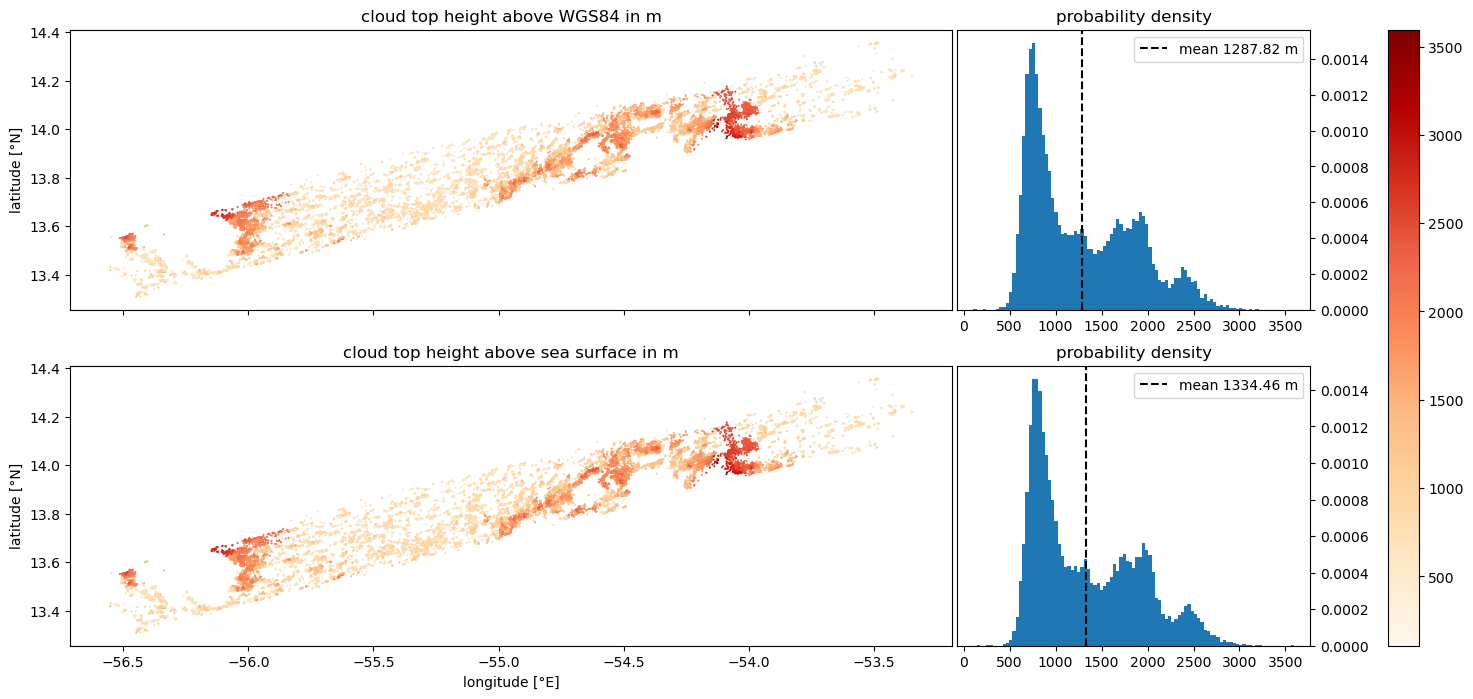

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 8), sharex=True)
axs[0].scatter(lon, lat, c=height, marker='o', s=2, edgecolor=None, linewidth=0, norm=norm, cmap=cmap)
axs[0].set_title('cloud top height above WGS84 in m')
axs[0].set_ylabel('latitude [°N]')
divider = make_axes_locatable(axs[0])
ax = divider.append_axes('right', size='40%', pad=0.05)
ax.hist(height, bins=np.linspace(vmin, vmax, 100), density=True)
ax.set_title('probability density')
ax.yaxis.tick_right()
ax.axvline(np.mean(height), linestyle='dashed', color='k', label='mean {:.2f} m'.format(np.mean(height)))
ax.legend()
axs[1].scatter(lon, lat, c=height_above_geoid, marker='o', s=2, edgecolor=None, linewidth=0, norm=norm, cmap=cmap)
axs[1].set_title('cloud top height above sea surface in m')
axs[1].set_ylabel('latitude [°N]')
axs[1].set_xlabel('longitude [°E]')
divider = make_axes_locatable(axs[1])
ax = divider.append_axes('right', size='40%', pad=0.05)
ax.hist(height_above_geoid, bins=np.linspace(vmin, vmax, 100), density=True)
ax.set_title('probability density')
ax.yaxis.tick_right()
ax.axvline(np.mean(height_above_geoid), linestyle='dashed', color='k', label='mean {:.2f} m'.format(np.mean(height_above_geoid)))
ax.legend()
plt.colorbar(sm, ax=axs)

## Make a 3D plot

As the stereo points are points on the cloud surface located in 3D space, we can also do a 3D plot. We will use a few different viewing settings, which can also be individually adjusted using the `elev` and `azim` arguments of the `ax.view_init` setting.

In [11]:
import matplotlib.ticker as ticker

In [12]:
#settings for plots 
s = 0.1 #markersize
cmap = 'viridis' #colormap
vmin = np.min(height)
vmax = np.max(height)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

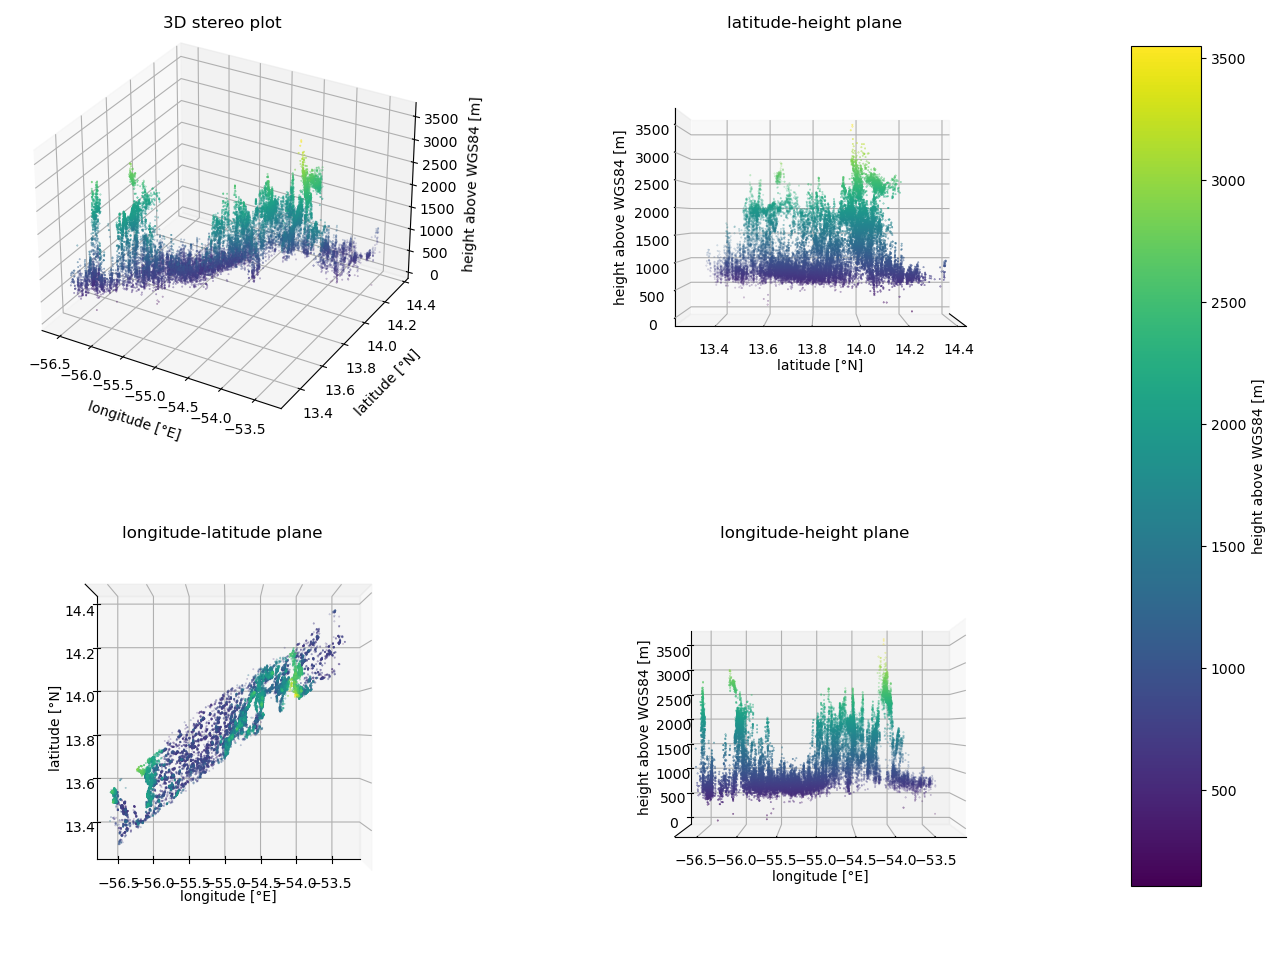

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(14,12), subplot_kw=dict(projection='3d'))

ax = axs[0,0]
ax.scatter(lon, lat, height, c=height, marker='o', norm=norm, cmap=cmap, s=s, linewidths=None, edgecolors=None)
ax.set_xlabel('longitude [°E]', labelpad=6.0)
ax.set_ylabel('latitude [°N]', labelpad=6.0)
ax.set_zlabel('height above WGS84 [m]', labelpad=6.0)
ax.view_init(elev=None, azim=None)
ax.set_title('3D stereo plot', y=1.02)

ax = axs[0,1]
ax.scatter(lon, lat, height, c=height, marker='o', norm=norm, cmap=cmap, s=s, linewidths=None, edgecolors=None)
ax.set_ylabel('latitude [°N]', labelpad=6.0)
ax.set_zlabel('height above WGS84 [m]', labelpad=6.0)
ax.view_init(elev=0, azim=0)
ax.set_title('latitude-height plane', y=1.02)
ax.xaxis.set_major_locator(ticker.NullLocator())

ax = axs[1,0]
ax.scatter(lon, lat, height, c=height, marker='o', norm=norm, cmap=cmap, s=s, linewidths=None, edgecolors=None)
ax.set_xlabel('longitude [°E]', labelpad=4.0)
ax.set_ylabel('latitude [°N]', labelpad=6.0)
ax.view_init(elev=90, azim=-90)
ax.set_title('longitude-latitude plane', y=1.02)
ax.zaxis.set_major_locator(ticker.NullLocator())

ax = axs[1,1]
ax.scatter(lon, lat, height, c=height, marker='o', norm=norm, cmap=cmap, s=s, linewidths=None, edgecolors=None)
ax.set_xlabel('longitude [°E]', labelpad=6.0)
ax.set_zlabel('height above WGS84 [m]', labelpad=10.0)
ax.view_init(elev=0, azim=-90)
ax.set_title('longitude-height plane', y=1.02)
ax.yaxis.set_major_locator(ticker.NullLocator())

plt.subplots_adjust(bottom=0.1, right=0.9)
cax = plt.axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cax, label='height above WGS84 [m]', fraction=0.02, shrink=2.0, aspect=40)

The 3D plots show the scene from different perspectives. It can be seen that the tracking algorithm finds points in both cloud layers down to a base height of approximately 1000m. Below, there are also some points which are probably outliers due to some wrong identifications.

## Project points to specMACS measurements

We will start to project the points found from the stereographic reconstruction to the specMACS maps which can be found [here](https://macsserver.physik.uni-muenchen.de/campaigns/EUREC4A/maps/). To do so, we need to import some further packages and we will define two functions to get the maps from the server.

In [14]:
from cartopy.io.img_tiles import GoogleWTS
from PIL import Image
import six 
import cartopy.crs as ccrs

In [15]:
class DefaultTileWTS(GoogleWTS):
    def get_image(self, tile):
        if six.PY3:
            from urllib.request import urlopen, Request, HTTPError, URLError
        else:
            from urllib2 import urlopen, Request, HTTPError, URLError

        url = self._image_url(tile)
        try:
            request = Request(url)
            fh = urlopen(request)
            im_data = six.BytesIO(fh.read())
            fh.close()
            img = Image.open(im_data)

        except (HTTPError, URLError) as err:
            img = self._default_tile(tile)

        img = img.convert(self.desired_tile_form)
        return img, self.tileextent(tile), 'lower'

class specMACSPTiles(DefaultTileWTS):
    def __init__(self, flight_segment_id):
        super(specMACSPTiles, self).__init__(desired_tile_form="RGBA")
        self.flight_segment_id = flight_segment_id
        self.empty_tile = Image.fromarray(np.full((256, 256, 4), (255, 255, 255, 0), dtype=np.uint8))

    def _default_tile(self, tile):
        return self.empty_tile

    def _image_url(self, tile):
        x, y, z = tile
        return f"https://macsserver.physik.uni-muenchen.de/campaigns/EUREC4A/maps/tiles/{self.flight_segment_id}/{z}/{x}/{y}.png"

In [16]:
#get specMACS tile
specmacs = specMACSPTiles(segment['segment_id'])

In [17]:
#get vmin and vmax using quantiles such that outliers will not influence the colorbar too much
q = 0.98
vmin = np.quantile(height, (1-q)/2)
vmax = np.quantile(height, q+(1-q)/2)

cmap = 'OrRd'
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

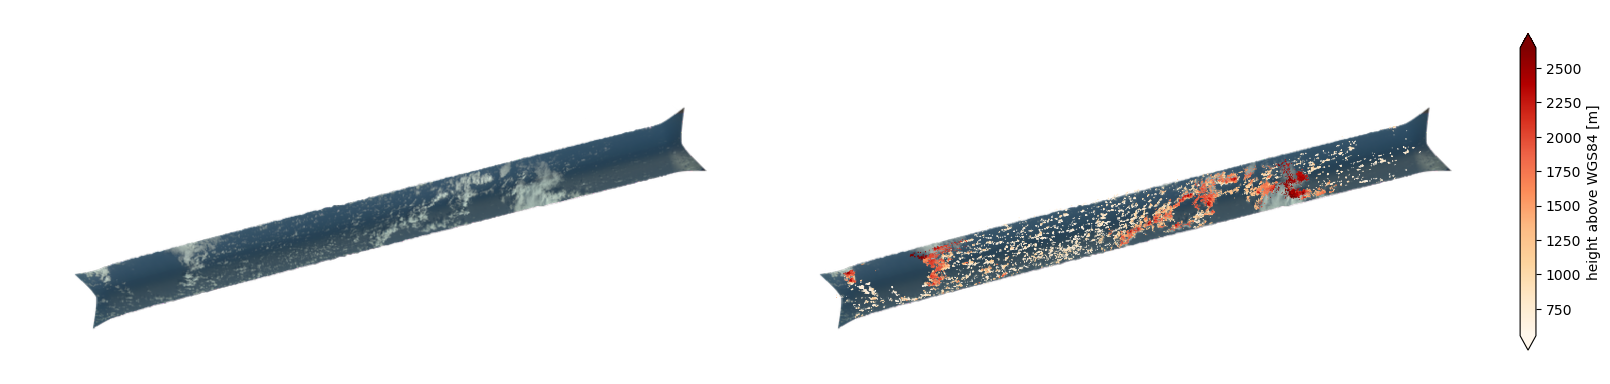

In [18]:
fig = plt.figure(figsize=(16, 8), constrained_layout=True)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.set_extent([np.floor(np.min(lon)), np.ceil(np.max(lon)), np.floor(np.min(lat)), np.ceil(np.max(lat))], crs=ccrs.PlateCarree())
ax.add_image(specmacs, 8) # the number is an integer and represents the detail level. It is logarithmic, small values are coarse, large values are fine.
ax.set_axis_off()
ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.set_extent([np.floor(np.min(lon)), np.ceil(np.max(lon)), np.floor(np.min(lat)), np.ceil(np.max(lat))], crs=ccrs.PlateCarree())
ax.add_image(specmacs, 8) # the number is an integer and represents the detail level. It is logarithmic, small values are coarse, large values are fine.
ax.set_axis_off()
im = ax.scatter(lon, lat, c=height, marker="o", s=0.4, edgecolor=None, linewidth=0, norm=norm, cmap=cmap)
fig.colorbar(im, label='height above WGS84 [m]', extend='both', shrink=0.4)

The projection of the points to the specMACS map on the right shows that most of the clouds, in particular the small cumulus clouds are well identified and located by the stereographic reconstruction method. The only exception is the higher and thicker cloud toward the end of the leg. This cloud lacks contrasts such that only its edges are identified well by the tracking algorithm.